<h1><center><font size="6">PROJET 7 : Implementez un modèle de scoring </font></center></h1>

L'objectif de ce projet est mettre en place un outils **Dashboard Interactif** à la destination des gestionnaires de compte , qui s'appuiera sur un modèle que nous auront établi pour identifier les clients en defaut de paiement ainsi choisir d'accorder ou non un prêt aux clients.


L'organigramme ci-dessous illustre l'ensemble des tables de données à notre ainsi que la relation entre ces différentes tables 

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" width="800"></img>

Dans ce notebook il sera question pour nous dans un premier temps de preprocesser les données , les traiter ensuite de réaliser un Benschmark sur plusieurs modèles et de choisir le modèle sera le plus performant. Les données d'entrée pour la construction du modèle se baseront sur le dataset **Application_train.csv** 

Le fichier *application_train* donne de multiples informations sur des clients qui ont effectué un emprunt ainsi que la mention le statut des différents clients (*Etiquette*).

Le fichier *application_test* a la même structure que *application_train* mais ne poccède pas d'etiquettes.

Les autres fichiers apportent un complément d'information sur  des emprunts antérieurs qui ont été accordés soit par d'autres institutions soit par la même banque.

### Definissons de maniere plus précise les différentes tables de données

**bureau.csv**
    Tous les crédits précédents des clients fournis par d'autres institutions financières qui ont été signalés au Bureau de Crédit (pour les clients qui ont un prêt dans notre échantillon). Pour chaque prêt dans notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait au Bureau de Crédit avant la date de la demande.

**bureau_balance.csv**
    Soldes mensuels des crédits précédents au Bureau de Crédit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent signalé au Bureau de Crédit - c'est-à-dire que la table a 
    (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons une certaine historique observable pour les crédits précédents) lignes.

**POS_CASH_balance.csv**
    Instantanés mensuels des soldes des crédits précédents (POS - points de vente et prêts en espèces) que le demandeur avait avec Home Credit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que la table a 
    (# de prêts dans l'échantillon * # de crédits précédents relatifs * # de mois pour lesquels nous avons une certaine historique observable pour les crédits précédents) lignes.

**credit_card_balance.csv**
    Instantanés mensuels des soldes des cartes de crédit précédentes que le demandeur a chez Home Credit. Cette table a une ligne pour chaque mois de l'historique de chaque crédit précédent chez Home Credit (crédit à la consommation et prêts en espèces) lié aux prêts de notre échantillon - c'est-à-dire que la table a (# de prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois pour lesquels nous avons une certaine historique observable pour la carte de crédit précédente) lignes.

**previous_application.csv**
    
Toutes les demandes antérieures de prêts Home Credit des clients qui ont des prêts dans notre échantillon. Il y a une ligne pour chaque demande antérieure liée aux prêts dans notre échantillon de données

**installments_payments.csvv*
    
Historique des remboursements pour les crédits précédemment octroyés chez Home Credit liés aux prêts de notre échantillon.
     Il y a a) une ligne pour chaque paiement effectué plus
     b) une ligne pour chaque paiement manqué. Une ligne équivaut à un paiement d'une échéance ou à une échéance correspondant à un paiement d'un crédit précédent de Home Credit lié aux prêts de notre échantillon."

*HomeCredit_columns_description.csvv
    Ce fichier contient des descriptions pour les colonnes dans les différents fichiers de données."


# Librairies

In [36]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [37]:
import pandas as pd
import numpy as np
import glob
import pickle
import os
import shap
import joblib
import matplotlib.pyplot as plt
from tools import data_description, post_treatment
import glob
import seaborn as sns
from tqdm import tqdm
import phik

In [38]:
pd.set_option("display.max_rows", 250)
# initialisation du seed et du repertoire principal

SEED = 123

In [39]:
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["TARGET"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["TARGET"],
                         predict_unseen["prediction_label"],
                         labels=unique_label), 
        index=['{:}'.format(x) for x in unique_label], 
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

In [40]:
def dataframe_compare(df1, df2):
    # Comparaison des colonnes, ici identifier les colonnes différentes l'une de l'autre
    cols_df1 = set(df1.select_dtypes(include='object').columns)
    cols_df2 = set(df2.select_dtypes(include='object').columns)

    # Colonnes communes
    common_cols = cols_df1.intersection(cols_df2)

    dif_cols = cols_df1.difference(cols_df2).union(cols_df2.difference(cols_df1))

    # Nombres de colonnes communes et différentes
    num_common_cols = len(common_cols)
    num_different_cols = len(dif_cols)

    # Créer un graphique à barres
    fig1, ax1 = plt.subplots()
    ax1.bar(['common', 'differents'], [num_common_cols, num_different_cols], color=['blue', 'orange'])
    ax1.set_ylabel('Nombre de colonnes')
    ax1.set_title('Comparaison % colonnes')
    plt.show()
    print('Number of different columns:', num_different_cols)
    print('Different columns:', dif_cols)
    print('#####' * 20)

    different_occurrences = {}
    for col in common_cols:
        values_df1 = set(df1[col])
        values_df2 = set(df2[col])

        # Comparaison des occurrences
        if values_df1 != values_df2:
            print(col)

            if len(values_df1.difference(values_df2)) != 0:
                print(f'Nombre d\'attributs de {col} dans df1 est {len(values_df1)} , dans df2 est {len(values_df2)}')
                different_occurrences[col] = list(values_df1.difference(values_df2))

                print('*#*#'*25)

                print('L\'élément dans df1 qui est absent dans df2 est', different_occurrences[col])

                n_val_df1 = df1[col].value_counts()
                n_val_df2 = df2[col].value_counts()

                print(f'df1 {col}:\n{n_val_df1}')
                print(f'df2 {col}:\n{n_val_df2}')

            elif len(values_df2.difference(values_df1)) != 0:
                print(f'Nombre d\'attributs de {col} dans df1 est {len(values_df1)} , dans df2 est {len(values_df2)}')
                different_occurrences[col] = list(values_df2.difference(values_df1))

                print('*#*#'*25)

                print('L\'élément dans df2 qui est absent dans df1 est', different_occurrences[col])

                n_val_df1 = df1[col].value_counts()
                n_val_df2 = df2[col].value_counts()

                print(' ')
                print(f'df1 {col}:\n{n_val_df1}')
                print(' ')
                print(f'df2 {col}:\n{n_val_df2}')

    return different_occurrences

In [41]:
def plot_correlation_matrix(data, quant_vars=None, cat_vars=None, figsize=(10, 8)):
   

    if quant_vars:
        
        # Calculer la matrice de corrélation pour les variables quantitatives
        quant_corr_matrix = data[quant_vars].corr()
        
        # Tracer la matrice de corrélation pour les variables quantitatives
        plt.figure(figsize=figsize)
        sns.heatmap(quant_corr_matrix, annot=False, cmap='viridis', fmt=".2f", linewidths=.5)
        plt.title("Matrice de corrélation pour les variables quantitatives")
        plt.show()

    if cat_vars:
        
        # Calculer la matrice de corrélation pour les variables catégorielles
        cat_corr_matrix = data[cat_vars].phik_matrix()

        # Tracer la matrice de corrélation pour les variables catégorielles
        plt.figure(figsize=figsize)
        sns.heatmap(cat_corr_matrix, annot=False, cmap='viridis', fmt=".2f",  square=True, linewidths=.5)
        plt.title("phi_k corrélation pour les variables catégorielles")
        plt.show()


In [42]:
def plot_numerical_bylabel(data, col, size=[12, 6]):
    # Set up the subplot
    fig, axes = plt.subplots(1, 2, figsize=size)
    
    # Plot the distribution for target == 0 and target == 1 using seaborn kdeplot
    sns.kdeplot(data.loc[data['TARGET'] == 0, col], label='TARGET == 0', fill=True, ax=axes[0])
    sns.kdeplot(data.loc[data['TARGET'] == 1, col], label='TARGET == 1', fill=True, ax=axes[0])
    
    # Add boxplots to show median and quartiles
    sns.boxplot(x='TARGET', y=col, data=data, showfliers=False, palette='viridis', ax=axes[1])
    
    # Label the plot
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Density')
    axes[0].set_title('%s Distribution' % col)
    
    # Print out the correlation and average values
    corr = data['TARGET'].corr(data[col])
    avg_repaid = data.loc[data['TARGET'] == 0, col].median()
    avg_not_repaid = data.loc[data['TARGET'] == 1, col].median()
    
    print('The correlation between %s and the TARGET is %0.4f' % (col, corr))
    print('Median value for repaid loans: %0.4f' % avg_repaid)
    print('Median value for not repaid loans: %0.4f' % avg_not_repaid)
    
    # Show the plots
    plt.show()

In [43]:
def plot_categorical(df, categorical_column, kind='pie', figsize=(5,5)):
    """
    Trace un pie plot ou un bar plot pour une variable catégorielle dans un DataFrame.

    Paramètres :
    - df : DataFrame pandas
    - categorical_column : str, le nom de la colonne catégorielle dans le DataFrame
    - kind : str, le type de plot ('pie' ou 'bar')
    """
    category_counts = df[categorical_column].value_counts()

    if kind == 'pie':
        # Calculer l'espacement pour chaque catégorie
        explode_values = [0.05] * len(category_counts)  # Vous pouvez ajuster la valeur pour contrôler l'espacement

        # Tracer le pie plot avec l'espacement
        plt.figure(figsize=figsize)
        plt.pie(category_counts, labels=category_counts.keys(), autopct='%1.1f%%', startangle=90, explode=explode_values)
        plt.title(f'Pie Plot - {categorical_column}')
        plt.show()
    elif kind == 'bar':
        # Tracer le bar plot
        plt.figure(figsize=figsize)
        category_counts.plot(kind='bar')
        plt.title(f'Bar Plot - {categorical_column}')
        plt.xlabel(categorical_column)
        plt.ylabel('Count')
        plt.show()
    else:
        print("Type de plot non pris en charge. Utilisez 'pie' ou 'bar'.")

In [44]:
def plot_categorical_bylabel(data, col, size=[12, 6], xlabel_angle=0, title='', kind=None):
    '''use it to compare the distribution between label 1 and label 0'''
    if kind=='bar':
        plt.figure(figsize=size)
        l1 = data.loc[data.TARGET == 1, col].value_counts()
        l0 = data.loc[data.TARGET == 0, col].value_counts()
        plt.subplot(1, 2, 1)
        
        # Utiliser sns.barplot avec la palette de couleurs spécifiée
        sns.barplot(x=l1.index, y=l1.values, palette='viridis')
        plt.title('Default: ' + title)
        plt.xlabel(title, fontsize=12)
        plt.xticks(rotation=xlabel_angle)
        plt.subplot(1, 2, 2)
        
        # Utiliser sns.barplot avec la palette de couleurs spécifiée
        sns.barplot(x=l0.index, y=l0.values, palette='viridis')
        plt.title('Non-default: ' + title)
        plt.xlabel(title, fontsize=12)
        plt.xticks(rotation=xlabel_angle)
        plt.show()
    else: 
        plt.figure(figsize=size)
        l1 = data.loc[data.TARGET == 1, col].value_counts()
        l0 = data.loc[data.TARGET == 0, col].value_counts()
        
        plt.subplot(1, 2, 1)       
        # Utiliser plt.pie avec autopct pour ajuster automatiquement les labels
        plt.pie(l1.values, labels=l1.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '', startangle=90)
        plt.xlabel(title, fontsize=12)
        plt.title('Default: ' + title)
        plt.xticks(rotation=xlabel_angle)
        
        plt.subplot(1, 2, 2)
        # Utiliser plt.pie avec autopct pour ajuster automatiquement les labels
        plt.pie(l0.values, labels=l0.index, autopct=lambda p: '{:.1f}%'.format(p) if p > 1 else '', startangle=90)
        plt.xlabel(title, fontsize=12)
        plt.title('Non-default: ' + title)
        plt.xticks(rotation=xlabel_angle)
        plt.show()


# Construction du Modèle ML de classification

## Chargement des données et des librairies

In [10]:
application_train = pd.read_csv("application_train_prepro.csv")
application_test = pd.read_csv("input/application_test_prepro.csv")

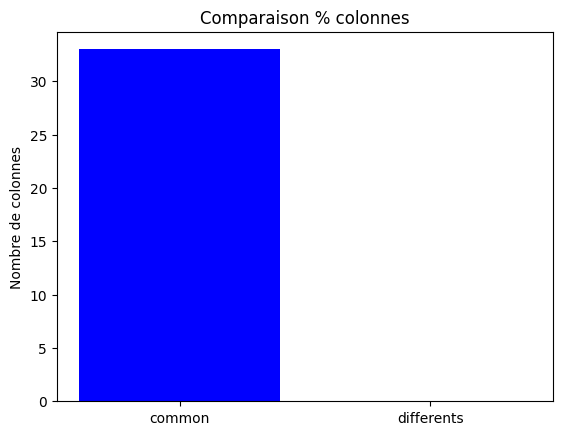

Number of different columns: 0
Different columns: set()
####################################################################################################


In [11]:
diff_cate = dataframe_compare(application_test, application_train)

In [12]:
from tools import get_target_encoder, pre_encoded_feature, get_impute_data, impute_data, get_scaling_data, scaling_data, train_model, encode_data_2
from tools import encode_data_2 , get_encoded_feature

## Preprocessing of the DATA

In [13]:
def training_process(application_train):
    # from BACKEND import process, _le, _impute
    application_train_treat = post_treatment(application_train)
    #application_train_treat = local_imputatation(application_train_treat, diff_cate)
    _le = get_target_encoder(application_train_treat)
    pre_encoded_application_train, feature_le_encoded, le_count = pre_encoded_feature(application_train_treat)
    _ohe = get_encoded_feature(pre_encoded_application_train)
    encoded_df = encode_data_2(pre_encoded_application_train, _le, _ohe)
    _impute = get_impute_data(encoded_df)
    impute_df = impute_data(encoded_df, _impute)
    _scaler = get_scaling_data(impute_df)
    scaling_df = scaling_data(impute_df, _scaler)
    return scaling_df, feature_le_encoded, _le, _ohe, _impute, _scaler

In [14]:
def test_process(application_train, feature_le_encoded, _le, _ohe, _impute, _scaler):
    # from BACKEND import process, _le, _impute
    application_train_treat = post_treatment(application_train)
    pre_encoded_application_train, feature_le_encoded, le_count = pre_encoded_feature(application_train_treat,feature_le_encoded)
    encoded_df = encode_data_2(pre_encoded_application_train, _le, _ohe)
    impute_df = impute_data(encoded_df, _impute)
    scaling_df = scaling_data(impute_df, _scaler)
    return scaling_df

In [15]:
def train_model(df):
    
    from sklearn.linear_model import LogisticRegression
    
    data = df.copy()
    x_columns = [name for name in data.columns if name not in ['SK_ID_CURR', 'TARGET']]
    
    x = data[x_columns]
    y = data['TARGET']

    # Train on the training data
    model = LogisticRegression(C=0.0001)
    model.fit(x, y)

    return model

In [16]:
print('######'*25)

######################################################################################################################################################


## Test sur un model log_simpliste

In [17]:
scaling_df, feature_le_encoded, _le, _ohe, _impute, _scaler = training_process(application_train)
model = train_model(scaling_df)

In [18]:
model.predict_proba(scaling_df.drop(['TARGET','SK_ID_CURR'], axis=1))

array([[0.88472418, 0.11527582],
       [0.95731128, 0.04268872],
       [0.92299119, 0.07700881],
       ...,
       [0.93552909, 0.06447091],
       [0.92512795, 0.07487205],
       [0.95343895, 0.04656105]])

## Sauvegarde du modèle simpliste et des elements de préprocessing

In [19]:
# Pickle approche locale
import os
import pickle

save_dir = 'obj_save/'

# Vérifier si le répertoire existe, sinon le créer
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Dictionnaire contenant les objets à sauvegarder
objects_to_save = {
    "model": model,
    "_scaler": _scaler,
    "_impute": _impute,
    "_le": _le,
    "_ohe": _ohe,
    "feature_le_encoded": feature_le_encoded
}

# Sauvegarde des objets dans un fichier pour chaque clé
for key, obj in objects_to_save.items():
    with open(os.path.join(save_dir, f"{key}.pkl"), "wb") as write_file:
        pickle.dump(obj, write_file)

# Dictionnaire pour charger les objets sauvegardés
loaded_objects = {}

# Chargement des objets à partir des fichiers
for key in objects_to_save.keys():
    with open(os.path.join(save_dir, f"{key}.pkl"), "rb") as read_file:
        loaded_objects[key] = pickle.load(read_file)

# Accès aux objets chargés (par exemple, loaded_objects["model"])

## Test du process sur un seul individu dont l'identifiant est connu

In [17]:
from backend import process_2

In [21]:
idx = 100001
mask = application_test['SK_ID_CURR']== idx
df = application_test[mask]
model = loaded_objects["model"]
_scaler = loaded_objects["_scaler"]
_impute = loaded_objects["_impute"]
_le = loaded_objects["_le"]
_ohe = loaded_objects["_ohe"]

In [22]:
mask = application_test['SK_ID_CURR'] == 100001
row_select = application_test[mask]
row_select_pre = process_2(row_select,feature_le_encoded)
model.predict_proba(row_select_pre.drop(['SK_ID_CURR'], axis=1))[0][0]

0.942880246498514

# Apprentissage supervisé du Modèle de classification + Tracking avec MLFLOW

In [20]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, confusion_matrix

import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
from tqdm import tqdm
import joblib
import pandas as pd
import numpy as np

import pycaret
from pycaret.classification import *

In [21]:
from sklearn.metrics import make_scorer
from pycaret.classification import ClassificationExperiment
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

In [22]:
import sys
sys.version

'3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]'

In [23]:
print(mlflow.__version__)

2.10.1


## Preprocessing

In [17]:
%%time
Data_exp, feature_le_encoded, _le, _ohe, _impute, _scaler= training_process(application_train)

CPU times: total: 2min 49s
Wall time: 2min 54s


## Benschmark sommaire des différents modèles de classification applicables

In [24]:
%%time
# Diviser le jeu de données en ensemble d'entraînement et de test (70% d'entraînement)
X_train, X_test, y_train, y_test = train_test_split(Data_exp.drop('TARGET', axis=1), Data_exp['TARGET'], test_size=0.25, random_state=SEED, stratify=Data_exp['TARGET'])

CPU times: total: 2 s
Wall time: 2.05 s


In [25]:
# Define your custom scoring function
def business_score(y_true, y_pred, **kwargs):
    # Implement your custom scoring logic here
    # y_true: actual labels
    # y_pred: predicted probabilities or labels
    # kwargs: additional arguments (if needed)
    # Return the custom score

    # Example: Calculate the maker score (replace this with your logic)
    N = len(y_true)  # Replace with your actual calculation
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    cost = -(10*fn+fp)

    return cost

# Define your custom scoring function
def F_beta(y_true, y_pred,beta=3 , **kwargs):
    # Implement your custom scoring logic here
    # y_true: actual labels
    # y_pred: predicted probabilities or labels
    # kwargs: additional arguments (if needed)
    # Return the custom score

    # Example: Calculate the maker score (replace this with your logic)
    N = len(y_true)  # Replace with your actual calculation
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = tp/(tp+fp) 
    recall = tp/(tp+fn)

    fbeta = (1+beta**2)*precision*recall/(beta**2*precision+recall)

    return fbeta
    
business_scorer = make_scorer(business_score, greater_is_better=True)
custom_metric_1 = {"name": "b_score", "score_func": business_score, "greater_is_better": True, "id": "b_score"}

# Créer un descripteur pour la métrique personnalisée
fbeta = make_scorer(F_beta, greater_is_better=True)
custom_metric_2 = {"name": "F_beta", "score_func": F_beta, "greater_is_better": True, "id": "F_beta"}

### Liste des modèles applicables 

In [30]:
%%time
from pycaret.classification import ClassificationExperiment
session_prim = ClassificationExperiment()

# Ajouter la métrique personnalisée à la bibliothèque de métriques de PyCaret
session_prim.setup(data=pd.concat([X_train,y_train], axis=1), normalize=False, target='TARGET', train_size=0.7, ignore_features=['SK_ID_CURR'], data_split_stratify=True, fold=3, session_id=SEED, 
                   log_experiment=True, experiment_name='First_Benschmark', numeric_imputation=None, categorical_imputation="drop")

session_prim.add_metric(**custom_metric_1)
session_prim.add_metric(**custom_metric_2)

,Description,Value
0,Session id,123
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(230633, 436)"
4,Transformed data shape,"(230633, 435)"
5,Transformed train set shape,"(161443, 435)"
6,Transformed test set shape,"(69190, 435)"
7,Ignore features,1
8,Numeric features,434
9,Preprocess,True


CPU times: total: 12 s
Wall time: 13.1 s


Name                                                            F_beta
Display Name                                                    F_beta
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                                             make_scorer(F_beta)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: F_beta, dtype: object

In [31]:
%%time
algos = session_prim.models()
print(algos)

                                     Name  \
ID                                          
lr                    Logistic Regression   
knn                K Neighbors Classifier   
nb                            Naive Bayes   
dt               Decision Tree Classifier   
svm                   SVM - Linear Kernel   
rbfsvm                SVM - Radial Kernel   
gpc           Gaussian Process Classifier   
mlp                        MLP Classifier   
ridge                    Ridge Classifier   
rf               Random Forest Classifier   
qda       Quadratic Discriminant Analysis   
ada                  Ada Boost Classifier   
gbc          Gradient Boosting Classifier   
lda          Linear Discriminant Analysis   
et                 Extra Trees Classifier   
xgboost         Extreme Gradient Boosting   
lightgbm  Light Gradient Boosting Machine   
dummy                    Dummy Classifier   

                                                  Reference  Turbo  
ID                            

In [32]:
%%time
# Utiliser la métrique personnalisée dans compare_models
tops_models = session_prim.compare_models(sort='F1', include=['lr', 'nb', 'dt', 'svm', 'lda', 'lightgbm','rf', 'xgboost'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,b_score,F_beta,TT (Sec)
nb,Naive Bayes,0.1383,0.5226,0.9633,0.0830,0.1529,0.0050,0.0323,-47806.3333,0.4676,2.5167
dt,Decision Tree Classifier,0.8537,0.5383,0.1623,0.1427,0.1519,0.0722,0.0723,-40629.0000,0.1601,11.2033
xgboost,Extreme Gradient Boosting,0.9176,0.7480,0.0503,0.4155,0.0897,0.0735,0.1220,-41568.3333,0.0551,6.0800
lda,Linear Discriminant Analysis,0.9184,0.7545,0.0395,0.4403,0.0725,0.0600,0.1127,-41946.0000,0.0435,8.0600
lightgbm,Light Gradient Boosting Machine,0.9196,0.7646,0.0297,0.5347,0.0563,0.0482,0.1118,-42265.6667,0.0328,3.1433
lr,Logistic Regression,0.9192,0.7538,0.0189,0.4915,0.0363,0.0306,0.0840,-42708.3333,0.0209,24.8400
rf,Random Forest Classifier,0.9193,0.7082,0.0002,0.3333,0.0005,0.0004,0.0071,-43435.0000,nan,15.4367
svm,SVM - Linear Kernel,0.9193,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-43443.3333,nan,3.0533


CPU times: total: 20.4 s
Wall time: 4min 5s


In [33]:
%%time
session_prim.pull()

CPU times: total: 0 ns
Wall time: 0 ns


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,b_score,F_beta,TT (Sec)
nb,Naive Bayes,0.1383,0.5226,0.9633,0.0830,0.1529,0.0050,0.0323,-47806.3333,0.4676,2.5167
dt,Decision Tree Classifier,0.8537,0.5383,0.1623,0.1427,0.1519,0.0722,0.0723,-40629.0000,0.1601,11.2033
xgboost,Extreme Gradient Boosting,0.9176,0.7480,0.0503,0.4155,0.0897,0.0735,0.1220,-41568.3333,0.0551,6.0800
lda,Linear Discriminant Analysis,0.9184,0.7545,0.0395,0.4403,0.0725,0.0600,0.1127,-41946.0000,0.0435,8.0600
lightgbm,Light Gradient Boosting Machine,0.9196,0.7646,0.0297,0.5347,0.0563,0.0482,0.1118,-42265.6667,0.0328,3.1433
lr,Logistic Regression,0.9192,0.7538,0.0189,0.4915,0.0363,0.0306,0.0840,-42708.3333,0.0209,24.8400
rf,Random Forest Classifier,0.9193,0.7082,0.0002,0.3333,0.0005,0.0004,0.0071,-43435.0000,NaN,15.4367
svm,SVM - Linear Kernel,0.9193,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-43443.3333,NaN,3.0533


Globalement l'on a un recall mauvais , et le seul modele pour lequel le recall esy bon c'est Naivee Bayes , sauf qu'il présente une mauvaise précision. Ceci est du à la disparité entre les effectifs de classes . Nous allons par conséquent pénaliser la classe majoritaire.

# Prise en compte des disproportions entre la classe Minoritaire et la classe Majoritaire

In [26]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

In [45]:
def Plot_Confusion_Matrix(y_test,ypred,y_good,y_default):

    cfn_matrix = confusion_matrix(y_test,ypred)
    cfn_norm_matrix = np.array([[1.0/y_good,1.0/y_good],[1.0/y_default,1.0/y_default]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,ypred))

# Plot_Confusion_Matrix(y_test,ypred,y_good,y_default)

# Nouvelle approche from scratch

### Traintest split

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

In [28]:
Data_exp.columns = Data_exp.columns.str.replace('[^a-zA-Z0-9]', '_')

In [29]:
# Diviser le jeu de données en ensemble d'entraînement et de test (70% d'entraînement)
X_train, X_val, y_train, y_val = train_test_split(Data_exp.drop('TARGET', axis=1), Data_exp['TARGET'],
                                                  test_size=0.20, random_state=SEED, stratify=Data_exp['TARGET'])

In [30]:
from tqdm import tqdm
import joblib
import mlflow
import mlflow.sklearn
      # Set our tracking server uri for logging
mlflow.set_tracking_uri("http://127.0.0.1:5000/")

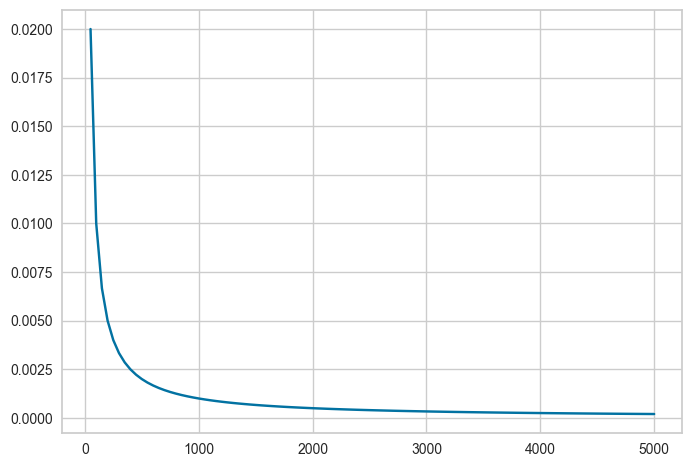

In [31]:
x= np.linspace(0,5000,101)
y = 1/x
plt.plot(x,y)

In [33]:
# Définissez votre propre fonction de coût métier
def cost_fn(y_true, y_pred):
    # Supposons que le coût d'un FN soit 10 fois supérieur au coût d'un FP
    cost = 1/(10 * np.sum((y_true == 1) & (y_pred == 0)) + np.sum((y_true == 0) & (y_pred == 1)))
    return cost

def op_threshold(estimator, X, y_true):
    y_probs = estimator.predict_proba(X)
    thresholds = np.linspace(0, 1, 101)
    costs = [cost_fn(y_true, (y_probs[:, 1] > t).astype(int)) for t in thresholds]
    o_threshold = thresholds[np.argmax(costs)]
    return o_threshold

def b_score(estimator, X, y_true):
    y_probs = estimator.predict_proba(X)
    thresholds = np.linspace(0, 1, 101)
    costs = [cost_fn(y_true, (y_probs[:, 1] > t).astype(int)) for t in thresholds]
    return np.max(costs)

def calculate_optimal_metrics(y_true, y_probs):
    thresholds = np.linspace(0, 1, 101)
    costs = [cost_fn(y_true, (y_probs[:, 1] > t).astype(int)) for t in thresholds]
    
    threshold_optimal = thresholds[np.argmax(costs)]
    optimal_cost = np.max(costs)
    
    y_pred = (y_probs[:, 1] > threshold_optimal).astype(int)
    precision_optimal = precision_score(y_true, y_pred)
    recall_optimal = recall_score(y_true, y_pred)
    f1_optimal = f1_score(y_true, y_pred)
    
    # Calcul de l'AUC optimal
    auc_optimal = roc_auc_score(y_true, y_probs[:, 1])
    
    return optimal_cost, precision_optimal, recall_optimal, f1_optimal, threshold_optimal, auc_optimal

# b_scorer = make_scorer(b_score, greater_is_better=False)

In [111]:
    # 'Random Forest': RandomForestClassifier(),
    # 'Logistic Regression': LogisticRegression(),
    # 'Decision Tree': DecisionTreeClassifier(),
    # 'XGBoost': XGBClassifier()
        # 'Logistic Regression': {'class_weight': [{0: 1, 1: k}]},
        # 'Decision Tree': {'class_weight': [{0: 1, 1: k}]},
        # 'XGBoost': {'n_estimators': [50, 100, 200], 'scale_pos_weight': [k]}
        # 'Random Forest': {'n_estimators': [3, 5, 10, 20], 'class_weight': [{0: 1, 1: k}]},

In [34]:
from sklearn.model_selection import StratifiedKFold
kfolds = StratifiedKFold(3)

  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 2 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*_

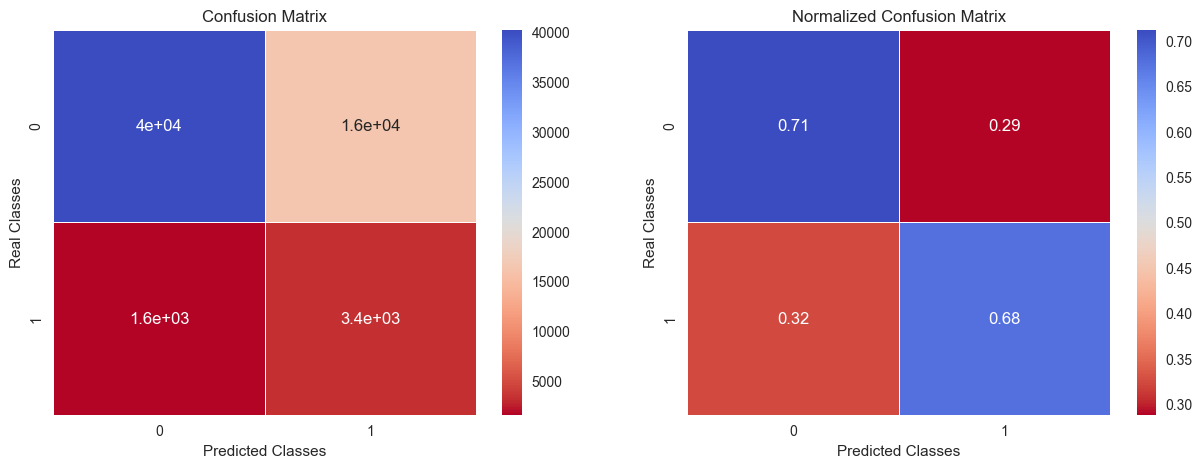

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56538
           1       0.17      0.68      0.27      4965

    accuracy                           0.71     61503
   macro avg       0.57      0.69      0.55     61503
weighted avg       0.90      0.71      0.77     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593


2024/03/13 15:09:42 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Costfonction(1/x on LGBM)' does not exist. Creating a new experiment.

  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 3 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*_

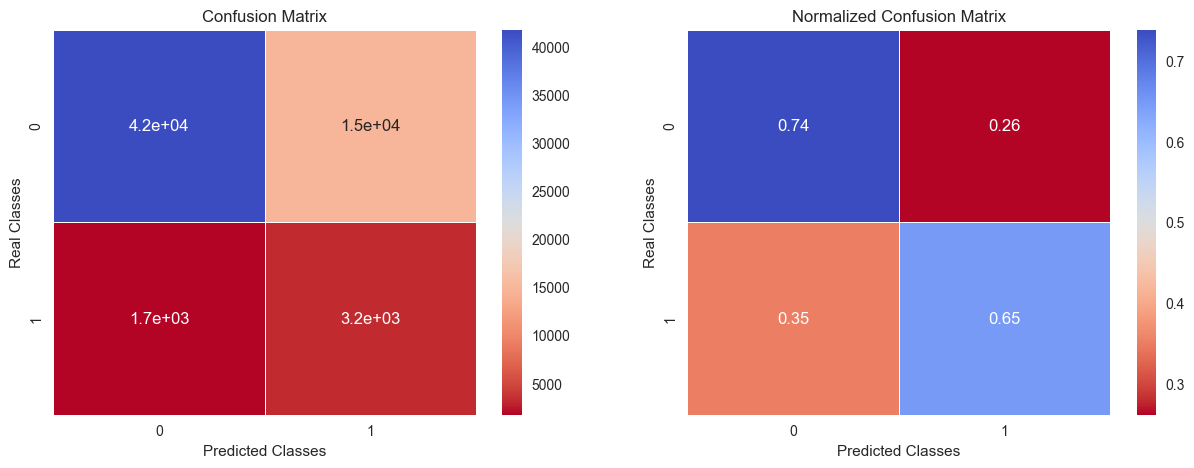

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56538
           1       0.18      0.65      0.28      4965

    accuracy                           0.73     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.73      0.79     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294



  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 4 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*_

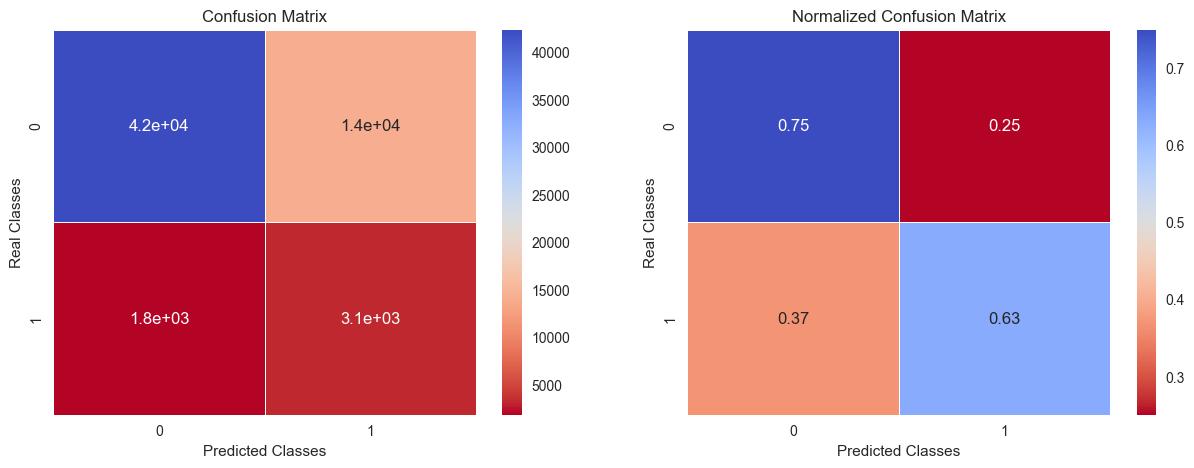

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56538
           1       0.18      0.63      0.28      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.74      0.80     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294
2,LightGBM,4,0.282094,0.632226,0.181550,0.000031,0.28,0.760509



  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 5 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*_

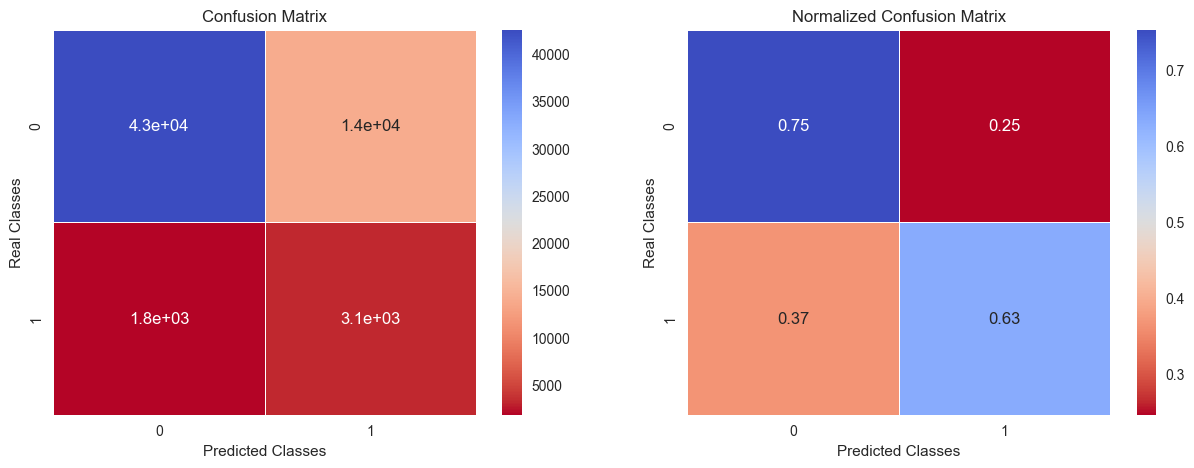

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56538
           1       0.18      0.63      0.29      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.74      0.80     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294
2,LightGBM,4,0.282094,0.632226,0.181550,0.000031,0.28,0.760509
3,LightGBM,5,0.285119,0.633635,0.183944,0.000031,0.33,0.760984



  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 6 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*

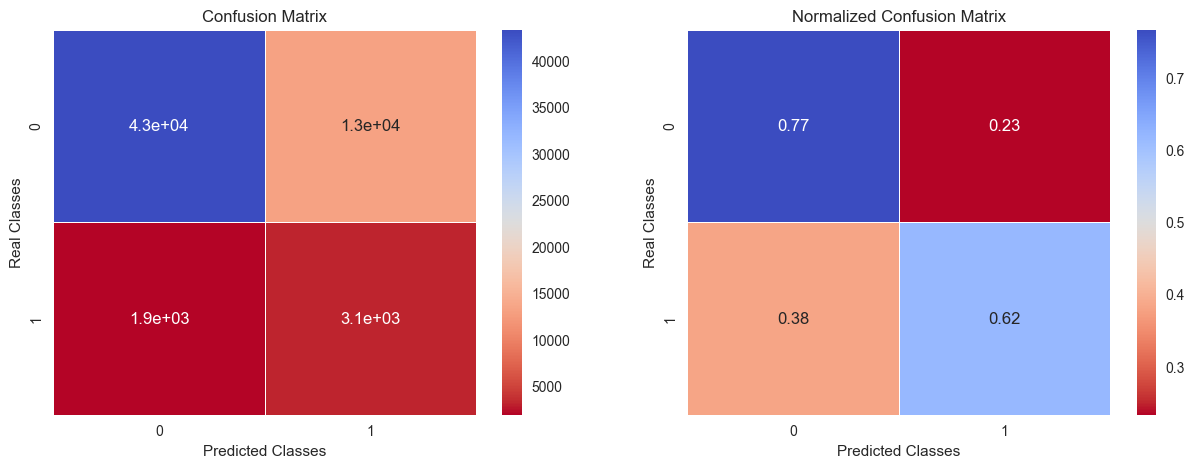

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.77      0.85     56538
           1       0.19      0.62      0.29      4965

    accuracy                           0.75     61503
   macro avg       0.57      0.69      0.57     61503
weighted avg       0.90      0.75      0.81     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294
2,LightGBM,4,0.282094,0.632226,0.181550,0.000031,0.28,0.760509
3,LightGBM,5,0.285119,0.633635,0.183944,0.000031,0.33,0.760984
4,LightGBM,6,0.289310,0.618127,0.188850,0.000031,0.38,0.761570



  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 7 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*_

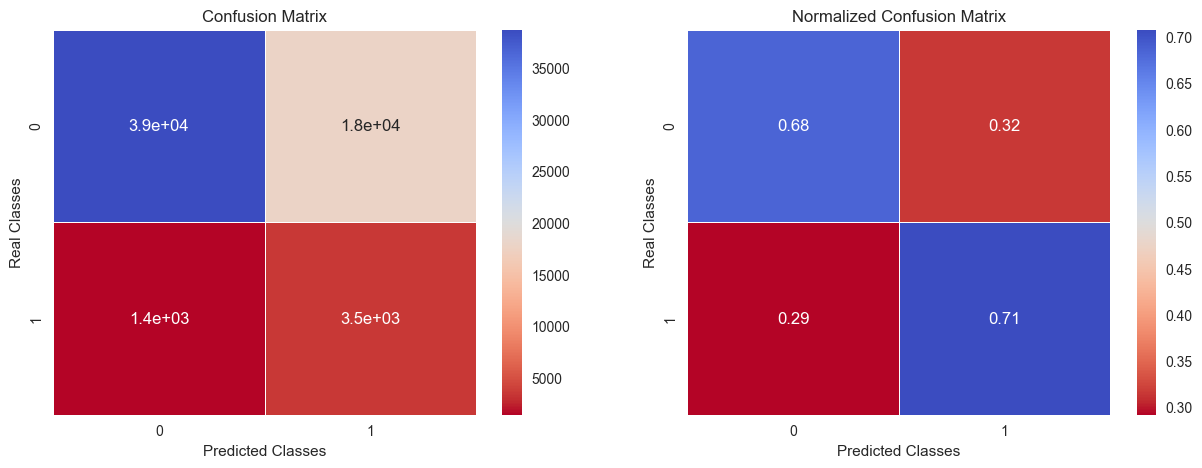

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.68      0.80     56538
           1       0.16      0.71      0.27      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.70      0.53     61503
weighted avg       0.90      0.69      0.76     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294
2,LightGBM,4,0.282094,0.632226,0.181550,0.000031,0.28,0.760509
3,LightGBM,5,0.285119,0.633635,0.183944,0.000031,0.33,0.760984
4,LightGBM,6,0.289310,0.618127,0.188850,0.000031,0.38,0.761570
5,LightGBM,7,0.267067,0.707956,0.164575,0.000031,0.36,0.760474



  0%|          | 0/1 [00:00<?, ?it/s]


LightGBM - Grid Search:
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Confusion Matrix of best ModelLGBMClassifier(), with 10 penalisation weight
_*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*__*_*_*_*_*

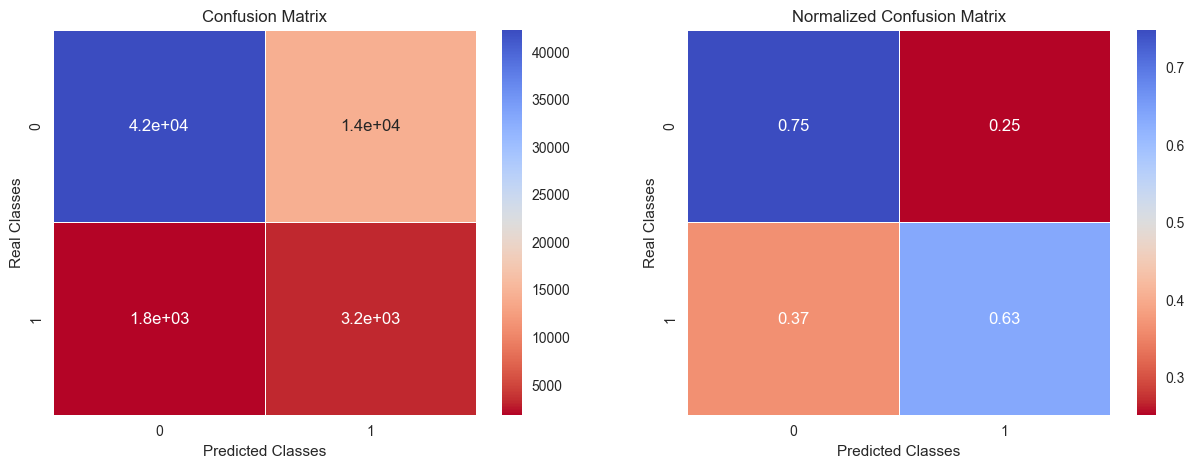

---Classification Report---
              precision    recall  f1-score   support

           0       0.96      0.75      0.84     56538
           1       0.18      0.63      0.28      4965

    accuracy                           0.74     61503
   macro avg       0.57      0.69      0.56     61503
weighted avg       0.90      0.74      0.80     61503

*/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/**/*/*
Les scores de lenchantillon de validation


,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294
2,LightGBM,4,0.282094,0.632226,0.181550,0.000031,0.28,0.760509
3,LightGBM,5,0.285119,0.633635,0.183944,0.000031,0.33,0.760984
4,LightGBM,6,0.289310,0.618127,0.188850,0.000031,0.38,0.761570
5,LightGBM,7,0.267067,0.707956,0.164575,0.000031,0.36,0.760474
6,LightGBM,10,0.281854,0.634441,0.181170,0.000031,0.49,0.759689



100%|██████████| 7/7 [37:33<00:00, 321.98s/it]


In [49]:
# Appliquez ici votre méthode de traitement du déséquilibre (par exemple, suréchantillonnage, génération synthétique).
y_good = y_val.value_counts()[0]
y_default = y_val.value_counts()[1]
    
# 2. Construction des modèles
models = {
    
    'LightGBM': LGBMClassifier(),

}

# Définir les métriques que vous souhaitez évaluer
scorings = {
    'accuracy': make_scorer(accuracy_score),
    'auc': make_scorer(roc_auc_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'op_threshold': op_threshold,
    'b_score': b_score,
}

# Création du DataFrame pour stocker les métriques
results = pd.DataFrame(columns=['Model', 'Penalization', 'val_f1', 'val_recall', 'val_precision', 'val_b_score','val_o_thresh','val_auc'])



metric_list = ['params','mean_train_precision','mean_train_accuracy','mean_train_f1','mean_train_recall','mean_train_auc','mean_train_b_score', 
               'mean_train_op_threshold','mean_test_precision','mean_test_accuracy','mean_test_f1','mean_test_recall','mean_test_auc','mean_test_b_score', 
               'mean_test_op_threshold' ]

# CV results
results_grid_cv = pd.DataFrame()

weights = [2, 3, 4, 5, 6, 7, 10]

for k in tqdm(weights):
    # Définition des grilles d'hyperparamètres à tester pour chaque modèle
    param_grids = {
        'LightGBM': {'n_estimators': [None, 10, 15, 20, 30], 'scale_pos_weight': [k], 'num_leaves': [5, 15, 20, 31]},
    }

    # Utilisation de GridSearchCV pour trouver les meilleures combinaisons d'hyperparamètres pour chaque modèle
    for model_name, model in tqdm(models.items()):
        print(f"\n{model_name} - Grid Search:")
        
        # Définition de la grille d'hyperparamètres pour le modèle
        param_grid = param_grids[model_name]

        # Création de l'objet GridSearchCV avec l'argument method
        grid_search = GridSearchCV(model, param_grid, cv=kfolds.split(X_train, y_train), scoring=scorings, n_jobs=-1, refit='b_score', return_train_score=True, verbose=2)
        
        with joblib.parallel_backend('loky'):
            grid_search.fit(X_train, y_train)
        
        # Extraction des resultats de la crossvalidation
        cv_results = pd.DataFrame(grid_search.cv_results_)[metric_list]
        mask = cv_results['params'] == grid_search.best_params_
        cv_results= cv_results[mask]
        # Obtention des meilleurs hyperparamètres
        best_params = grid_search.best_params_
        
        # Prediction on validation
        y_probs = grid_search.predict_proba(X_val)
        
        # 4. Calcul des métriques
        val_b_score, val_precision, val_recall, val_f1, val_o_thresh, auc_optimal = calculate_optimal_metrics(y_val, y_probs)
       
        print(f'Confusion Matrix of best Model{model}, with {k} penalisation weight')
        print('_*_*_*_*_*_'*35)
        print('_*_*_*_*_*_'*35)
        y_pred = (y_probs[:, 1] > val_o_thresh).astype(int)
        Plot_Confusion_Matrix(y_val,y_pred,y_good,y_default)
        
        # Ajout des métriques au DataFrame
        results = results.append({
            'Model': model_name,
            'Penalization': k,
            'val_f1': val_f1,
            'val_recall': val_recall,
            'val_precision': val_precision,
            'val_b_score': val_b_score,
            'val_o_thresh': val_o_thresh,
            'val_auc': auc_optimal
        }, ignore_index=True)

        print('*/*/*'*50)
        print('Les scores de l''enchantillon de validation')
        display(results)
        
        
        # Create a new MLflow Experiment
        mlflow.set_experiment("MLflow Costfonction(1/x on LGBM)")

        # Enregistrement des métriques dans MLflow
        with mlflow.start_run(run_name=f"{model_name}_weight{k}",nested=True):
            mlflow.log_param("model_name", model_name)
            mlflow.log_param("Params", grid_search.best_params_)
            mlflow.log_metric("val_f1", val_f1)
            mlflow.log_metric("val_recall", val_recall)
            mlflow.log_metric("val_precision", val_precision)
            mlflow.log_metric("val_b_score", val_b_score)
            mlflow.log_metric('val_o_thresh', val_o_thresh)
            mlflow.log_metric("val_auc", auc_optimal)
            
            for name in cv_results[mask].drop('params',axis=1):
                mlflow.log_metric(name, cv_results[name])
                
            mlflow.sklearn.log_model(grid_search.best_estimator_, f"{model_name}_weight{k}")

In [ ]:
# mlflow server --host 127.0.0.1 --port 5000

In [50]:
results.sort_values('val_b_score', ascending=False)

,Model,Penalization,val_f1,val_recall,val_precision,val_b_score,val_o_thresh,val_auc
4,LightGBM,6,0.289310,0.618127,0.188850,0.000031,0.38,0.761570
3,LightGBM,5,0.285119,0.633635,0.183944,0.000031,0.33,0.760984
1,LightGBM,3,0.280450,0.648338,0.178923,0.000031,0.22,0.760294
5,LightGBM,7,0.267067,0.707956,0.164575,0.000031,0.36,0.760474
0,LightGBM,2,0.272978,0.676536,0.170985,0.000031,0.15,0.759593
6,LightGBM,10,0.281854,0.634441,0.181170,0.000031,0.49,0.759689
2,LightGBM,4,0.282094,0.632226,0.181550,0.000031,0.28,0.760509


# Reentrainement du Modèle

In [77]:
# - Faire du feature engineering 
# - Supprimer des features non utiles , valeurs manquantes 
# -  Imputations des valeurs manquantes pas tres représentatives
# - Matrice de corrélations 

# - Faire un benschamark de plusieurs modèles , après une crossvalidations 
# - Afficher les Resultats train et test de chacun des modèles pour controler l'overfitting
# - Après le gridsearch realiser le calcul de des métriques  

In [52]:
# params={'n_estimators': 30, 'num_leaves': 31, 'scale_pos_weight': 6}
# model = LGBMClassifier(**params)
logged_model = 'runs:/828c084049ce42d8bca2b03b9f8c1e22/LightGBM_weight6'

# Load model as a PyFuncModel.
loaded_model = mlflow.sklearn.load_model(logged_model)
loaded_model.fit(Data_exp.drop(['TARGET','SK_ID_CURR'], axis=1), Data_exp['TARGET'])

[LightGBM] [Info] Number of positive: 24825, number of negative: 282686
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.217069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17546
[LightGBM] [Info] Number of data points in the train set: 307511, number of used features: 420
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432486
[LightGBM] [Info] Start training from score -2.432486


LGBMClassifier(n_estimators=30, scale_pos_weight=6)

In [55]:
# Create a new MLflow Experiment
mlflow.set_experiment("MLflow SAVING BEST_MODEL")

# Enregistrement des métriques dans MLflow
with mlflow.start_run(run_name='BEST_LGBM_MODEL',nested=True):
    mlflow.log_param("model_name", loaded_model.__class__.__name__)
    mlflow.log_param("Params", loaded_model.get_params())
    mlflow.sklearn.log_model(loaded_model, f"{loaded_model.__class__.__name__}")

Test du modèle sur un seul individu témoins

In [59]:
sample_idx = 100007
mask = Data_exp['SK_ID_CURR']== sample_idx
print('PREDICTION',loaded_model.predict(Data_exp[mask].drop(['TARGET','SK_ID_CURR'], axis=1)))
print('TRUE_TARGET',Data_exp[mask]['TARGET'].values)

PREDICTION [0]
TRUE_TARGET [0]


## Tracer de la courble roc et la courbe PR , pour controler le surapprentissage

In [113]:
def plot_roc_recall(x_train, y_train, x_test, y_test, weights=[2, 3, 4, 5, 6, 7, 10]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('Recall')
    ax1.set_ylabel('Precision')
    ax1.set_title('PR Curve')

    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')



    for w, k in zip(weights, 'bgrcmyk'):  # bgrcmykw
        params = {'n_estimators': 30, 'num_leaves': 31, 'scale_pos_weight': w}
        lr_model = LGBMClassifier(**params)
        lr_model.fit(x_train, y_train)
        pred_prob = lr_model.predict_proba(x_test)[:, 1]

        p, r, _ = precision_recall_curve(y_test, pred_prob)
        tpr, fpr, _ = roc_curve(y_test, pred_prob)

        ax1.plot(r, p, label=w)
        ax2.plot(tpr, fpr, label=w)
        
    
        


    ax1.legend(loc='lower left')
    ax2.legend(loc='lower left')

    plt.show()

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17799
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


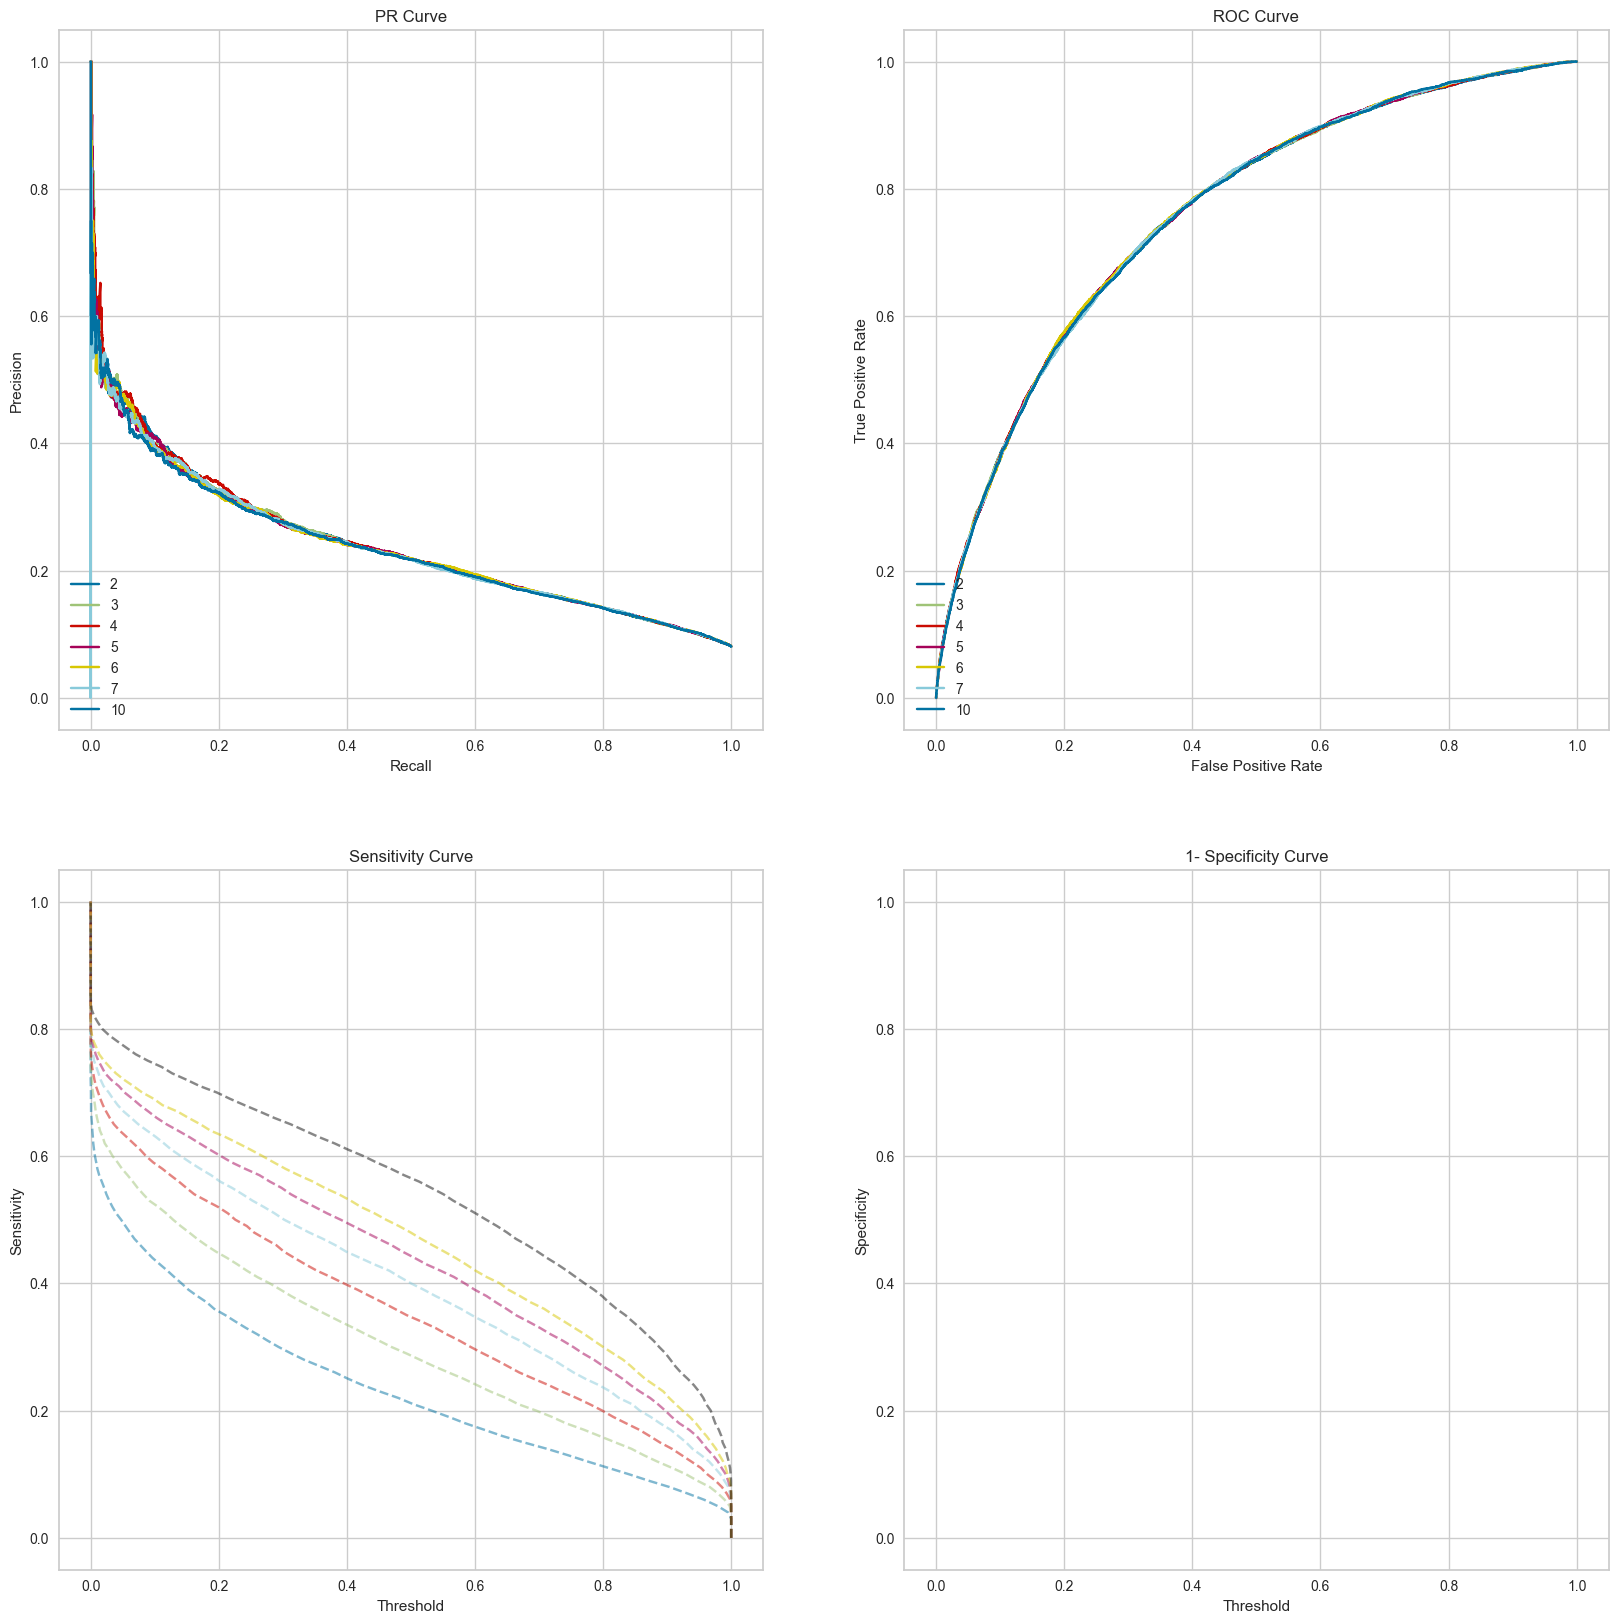

In [114]:
plot_roc_recall(X_train, y_train, X_val, y_val, weights=[2, 3, 4, 5, 6, 7, 10])

## Features Importance

## Global

In [ ]:
shap.__version__

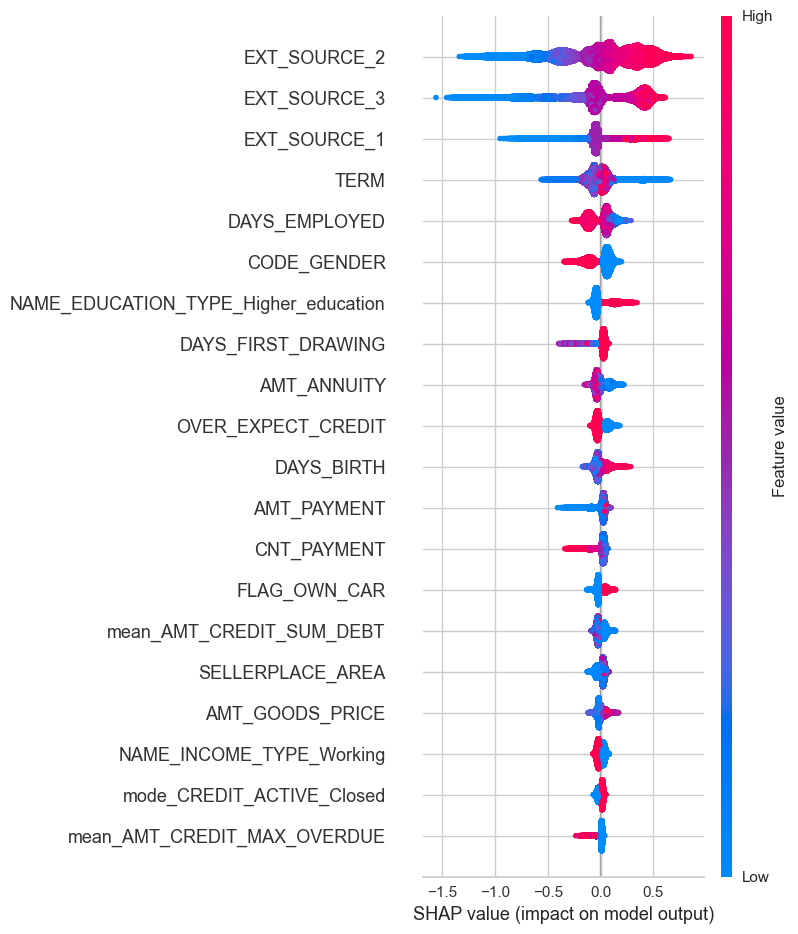

In [392]:
import shap
# Explain model predictions using shap library:
explainer = shap.Explainer(loaded_model)
shap_values = explainer.shap_values(Data_exp.drop(['TARGET','SK_ID_CURR'], axis=1))

# Plot summary_plot
shap.summary_plot(shap_values[0], Data_exp.drop(['TARGET','SK_ID_CURR'], axis=1), max_display=20)

In [579]:
import plotly.graph_objects as go
import plotly.io as pio
def plot_local_water(shap_values_loc, max_display = 15):

    # Extraction des valeurs SHAP, des noms de fonctionnalités et des données
    shap_values = shap_values_loc[0].values[:,1]
    feature_name = shap_values_loc[0].feature_names
    data_values = shap_values_loc[0].data

    # Création d'un DataFrame avec les valeurs SHAP, les noms de fonctionnalités et les données
    df_values = pd.DataFrame({"features": feature_name, 
                              "shap_values": shap_values, 
                              "data": data_values})
    
    # Trier les fonctionnalités par leur valeur SHAP absolue
    df_values["abs_shap_values"] = np.abs(df_values["shap_values"])
    df_values = df_values.sort_values("abs_shap_values", ascending=False).head(max_display)
    
    # Ajouter une ligne pour la somme des autres valeurs SHAP
    sum_others = df_values["shap_values"].sum()
    df_values.loc[len(df_values)] = ["Sum of other features", sum_others, np.nan, np.nan]
    
       # Créer un graphique waterfall
    fig = go.Figure(go.Waterfall(
        orientation="h",
        measure=["relative"] * len(df_values),
        y=df_values["features"],
        x=df_values["shap_values"],
        text=df_values["shap_values"].round(3),
        base=shap_values_loc[0].base_values[1],
        increasing={"marker": {"color": "red"}},
        decreasing={"marker": {"color": "green"}},
        alignmentgroup="Sum of other features",  # Identifiant pour l'alignement des barres
        offsetgroup="Sum of other features"  # Identifiant pour l'ajustement des étiquettes y
    ))
    
    # Mise en forme du titre et des axes
    fig.update_layout(
        title="Features importance client",
        xaxis_title="Shap value ()",
        # yaxis_title="Features",
        xaxis_tickangle=0,
        width=1000,  # Largeur de la figure en pixels
        height=600  # Hauteur de la figure en pixels
    )
    return fig

## Local

### Approche Shap

In [128]:
Data_exp[mask]['TARGET']

0    1
Name: TARGET, dtype: int64

In [450]:
sample_idx = 100002
mask = Data_exp['SK_ID_CURR']== sample_idx
shap_values_loc = explainer(Data_exp[mask].drop(['TARGET','SK_ID_CURR'], axis=1).to_numpy().reshape(1,-1))
shap_values_loc.feature_names = Data_exp.drop(['TARGET','SK_ID_CURR'], axis=1).columns.tolist()

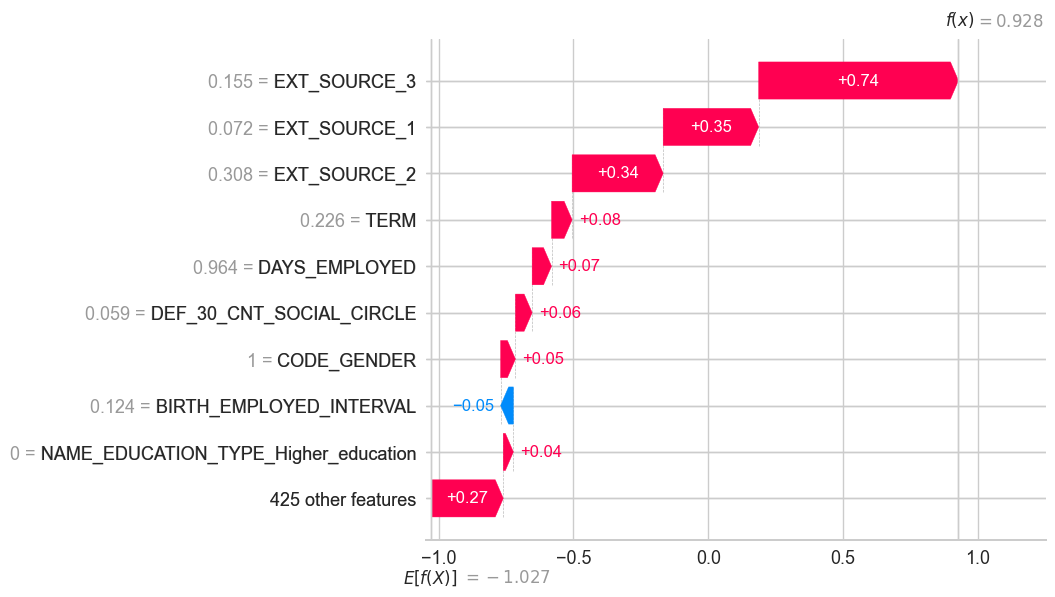

In [524]:
sample_idx = 100002
mask = Data_exp['SK_ID_CURR']== sample_idx

# Shap values of the customer
shap_values_loc = explainer(Data_exp[mask].drop(['TARGET','SK_ID_CURR'], axis=1).to_numpy().reshape(1,-1))

# Feature names
shap_values_loc.feature_names = Data_exp.drop(['TARGET','SK_ID_CURR'], axis=1).columns.tolist()

# raw_base_score = explainer.expected_value[1]
# raw_customer_score = explainer.expected_value[1] + shap_values_loc.values[:,:,1].sum()

# Clear the current figure
plt.clf()

# Waterfall plot of the shap values
fig = shap.waterfall_plot(shap_values_loc[0,:,1], max_display=10, show=True)

### Approche from scracht

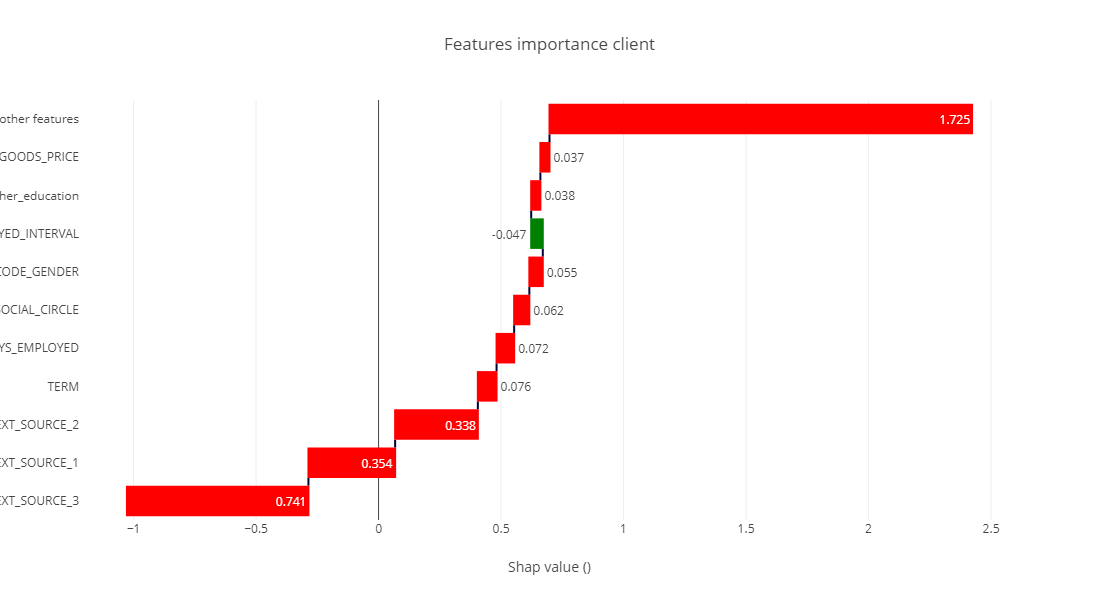

In [582]:
plot_local_water(shap_values_loc,max_display = 10)

In [584]:
pio.write_image(fig, 'waterfall_plot.png')

# Saving of the Best Model Experiment

In [143]:
save_dir = './obj_save/'

# Vérifier si le répertoire existe, sinon le créer
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Dictionnaire contenant les objets à sauvegarder
objects_to_save = {
    "model": loaded_model,
    "_scaler": _scaler,
    "_impute": _impute,
    "_le": _le,
    "_ohe": _ohe,
    "feature_le_encoded": feature_le_encoded
}

# Sauvegarde des objets dans un fichier pour chaque clé
for key, obj in objects_to_save.items():
    with open(os.path.join(save_dir, f"{key}.pkl"), "wb") as write_file:
        pickle.dump(obj, write_file)

# Dictionnaire pour charger les objets sauvegardés
loaded_objects = {}

# Chargement des objets à partir des fichiers
for key in objects_to_save.keys():
    with open(os.path.join(save_dir, f"{key}.pkl"), "rb") as read_file:
        loaded_objects[key] = pickle.load(read_file)

# Accès aux objets chargés (par exemple, loaded_objects["model"])

# Simulation sur l'ensemble du dataset Application_test

In [153]:
data_test = test_process(application_test, feature_le_encoded, _le, _ohe, _impute, _scaler)
loaded_model.predict_proba(data_test.drop('SK_ID_CURR', axis=1))

array([[0.82503399, 0.17496601],
       [0.60101362, 0.39898638],
       [0.89161784, 0.10838216],
       ...,
       [0.86230047, 0.13769953],
       [0.74851276, 0.25148724],
       [0.40491985, 0.59508015]])

In [188]:
sample_idx = 100091
mask = data_test['SK_ID_CURR']== sample_idx
loaded_model.predict_proba(data_test[mask].drop('SK_ID_CURR', axis=1))

array([[0.40926637, 0.59073363]])